In [70]:
# =========================
# CELL 2 — NETWORKS CONSTRUCTION
# =========================

# --- Libraries---
library(terra)
library(geodata)
library(dplyr)
library(eurostat)
library(sf)
library(countrycode)
library(readr)
library(purrr)
library(igraph)

# --- Paths ---
DATA_DIR <- "C:/Users/chiar/OneDrive/Desktop/Magistrale/manlio/project_44/data"
setwd(DATA_DIR)

SCI_FILE    <- "gadm1_nuts3_counties-gadm1_nuts3_counties - FB Social Connectedness Index - October 2021.tsv"
LEVELS_FILE <- "gadm1_nuts3_counties_levels.csv"

OUT_DIR <- file.path(DATA_DIR, "output_networks")
dir.create(OUT_DIR, showWarnings = FALSE)

# ------------------------------------------------------------
# 1) Read raw SCI edges + levels
# ------------------------------------------------------------

read_sci_pairs <- function(filepath) {
  # Read SCI pairs (TSV) and exclude USA as required by the task.
  read_tsv(filepath, show_col_types = FALSE) %>%
    filter(!grepl("^USA", user_loc), !grepl("^USA", fr_loc))
}

read_levels <- function(filepath) {
  # Read key-level table. For non-NUTS keys the ISO3 is typically the prefix of the key.
  read_csv(filepath, show_col_types = FALSE) %>%
    mutate(country = sub("^([A-Z]{3}).*$", "\\1", key))
}

# ------------------------------------------------------------
# 2) Fix country ISO3 for NUTS3 keys (EUROSTAT -> ISO3)
# ------------------------------------------------------------

map_nuts3_countries <- function(levels_df) {
  # NUTS3 keys are not ISO3-prefixed; map CNTR_CODE -> ISO3.
  nuts3_sf <- get_eurostat_geospatial(nuts_level = 3, year = 2016, output_class = "sf")

  nuts3_keys <- levels_df %>% filter(level == "nuts3") %>% pull(key)
  matched_cntr <- nuts3_sf$CNTR_CODE[match(nuts3_keys, nuts3_sf$id)]
  iso3 <- countrycode(matched_cntr, origin = "eurostat", destination = "iso3c")

  levels_df$country[levels_df$level == "nuts3"] <- iso3
  levels_df
}

# ------------------------------------------------------------
# 3) Join levels to SCI pairs + keep intra-country only
# ------------------------------------------------------------

prepare_edges_with_levels <- function(sci_df, levels_df) {
  # Attach country + level info to user_loc and fr_loc.
  # Keep only intra-country edges, and only target administrative levels.
  sci_df %>%
    left_join(levels_df, by = c("user_loc" = "key")) %>%
    left_join(levels_df, by = c("fr_loc"   = "key"), suffix = c("_user", "_fr")) %>%
    rename(level_user = level_user, level_fr = level_fr) %>%
    filter(!is.na(country_user), !is.na(country_fr)) %>%
    filter(country_user == country_fr) %>%
    mutate(country = country_user) %>%
    filter(level_user %in% c("gadm1", "gadm2", "nuts3"),
           level_fr   %in% c("gadm1", "gadm2", "nuts3")) %>%
    # Keep only edges where BOTH endpoints are of the SAME level type
    # (this is the most conservative interpretation of your description)
    filter(level_user == level_fr) %>%
    transmute(
      country,
      level = level_user,
      user_loc,
      fr_loc,
      scaled_sci
    )
}

# ------------------------------------------------------------
# 4) Enforce level priority per country (NUTS3 > GADM2 > GADM1)
# ------------------------------------------------------------

pick_best_level_per_country <- function(edges_df) {
  priority <- c("nuts3" = 3, "gadm2" = 2, "gadm1" = 1)

  best <- edges_df %>%
    distinct(country, level) %>%
    mutate(p = priority[level]) %>%
    group_by(country) %>%
    slice_max(order_by = p, n = 1, with_ties = FALSE) %>%
    ungroup() %>%
    select(country, level)

  edges_df %>% inner_join(best, by = c("country", "level"))
}

# ------------------------------------------------------------
# 5) Clean edges: remove self-loops, merge symmetric duplicates (mean weight)
# ------------------------------------------------------------

clean_edges_undirected <- function(edges_df) {
  # Remove self-loops
  edges_df <- edges_df %>% filter(user_loc != fr_loc)

  # Canonical ordering for undirected merge
  edges_df %>%
    mutate(
      a = pmin(user_loc, fr_loc),
      b = pmax(user_loc, fr_loc)
    ) %>%
    group_by(country, level, a, b) %>%
    summarise(weight = mean(scaled_sci, na.rm = TRUE), .groups = "drop") %>%
    rename(user_loc = a, fr_loc = b)
}

# ------------------------------------------------------------
# 6) Build node table (centroids) for each country+level
# ------------------------------------------------------------

# Load NUTS3 geometry once (EUROSTAT GISCO)
nuts3_shp <- get_eurostat_geospatial(nuts_level = 3, year = 2016, output_class = "sf")

# Helper: safer representative point than centroid for weird geometries
safe_point <- function(sf_geom) {
  # st_point_on_surface is safer than centroid for polygons with holes / invalid shapes.
  suppressWarnings(st_point_on_surface(sf_geom))
}

build_nodes_nuts3 <- function(node_codes, nuts3_shp) {
  regs <- nuts3_shp[match(node_codes, nuts3_shp$id), ]
  if (any(is.na(regs$id))) return(NULL)

  pts <- safe_point(regs$geometry)
  coords <- st_coordinates(pts)

  tibble(
    nodeCode   = node_codes,
    nodeID     = seq_along(node_codes),
    nodeLabel  = regs$NAME_LATN,
    longitude  = coords[, 1],
    latitude   = coords[, 2]
  )
}

build_nodes_gadm <- function(country_iso3, level, node_codes) {
  gadm_level <- if (level == "gadm1") 1 else 2

  gadm_data <- tryCatch(
    gadm(country_iso3, level = gadm_level, version = "3.6", path = DATA_DIR),
    error = function(e) NULL
  )
  if (is.null(gadm_data) || nrow(gadm_data) == 0) return(NULL)

  # NOTE: This mapping assumes SCI codes encode the admin index at the end.
  # It is a pragmatic approach and matches the common format used in SCI releases.
  node_ids <- if (level == "gadm1") {
    as.integer(gsub("\\D", "", node_codes))
  } else {
    as.integer(sub(".*_(\\d+)$", "\\1", node_codes))
  }

  # Guard against out-of-range indices
  ok <- !is.na(node_ids) & node_ids >= 1 & node_ids <= nrow(gadm_data)
  if (!all(ok)) {
    node_codes <- node_codes[ok]
    node_ids   <- node_ids[ok]
  }
  if (length(node_codes) == 0) return(NULL)

  pts <- terra::centroids(gadm_data)
  coords <- terra::crds(pts)[node_ids, , drop = FALSE]

  labels <- if (level == "gadm1") gadm_data$NAME_1[node_ids] else gadm_data$NAME_2[node_ids]

  tibble(
    nodeCode   = node_codes,
    nodeID     = seq_along(node_codes),
    nodeLabel  = labels,
    longitude  = coords[, 1],
    latitude   = coords[, 2]
  )
}

# ------------------------------------------------------------
# 7) Build one network (nodes+edges tables) for a given country
# ------------------------------------------------------------

build_country_network <- function(country_iso3, level, edges_country, nuts3_shp) {
  node_codes <- sort(unique(c(edges_country$user_loc, edges_country$fr_loc)))

  nodes <- if (level == "nuts3") {
    build_nodes_nuts3(node_codes, nuts3_shp)
  } else {
    build_nodes_gadm(country_iso3, level, node_codes)
  }

  if (is.null(nodes) || nrow(nodes) == 0) return(NULL)

  # Map nodeCode -> nodeID (stable sequential IDs)
  id_map <- setNames(nodes$nodeID, nodes$nodeCode)

  edges <- edges_country %>%
    transmute(
      nodeID_from  = unname(id_map[user_loc]),
      nodeID_to    = unname(id_map[fr_loc]),
      country_name = country_iso3,
      country_ISO3 = country_iso3,
      weight
    ) %>%
    filter(!is.na(nodeID_from), !is.na(nodeID_to))

  if (nrow(edges) == 0) return(NULL)

  list(nodes = nodes, edges = edges)
}

# ------------------------------------------------------------
# 8) Run the full pipeline
# ------------------------------------------------------------

df_raw     <- read_sci_pairs(SCI_FILE)
levels_raw <- read_levels(LEVELS_FILE)
levels_ok  <- map_nuts3_countries(levels_raw)

edges_lvl <- prepare_edges_with_levels(df_raw, levels_ok)
edges_lvl <- pick_best_level_per_country(edges_lvl)
edges_cln <- clean_edges_undirected(edges_lvl)

# Build networks (top 100 countries by number of available nodes, excluding USA already)
country_rank <- edges_cln %>%
  group_by(country) %>%
  summarise(n_nodes = n_distinct(c(user_loc, fr_loc)), .groups = "drop") %>%
  arrange(desc(n_nodes)) %>%
  slice_head(n = 100)

edges_top <- edges_cln %>% semi_join(country_rank, by = "country")

# Determine the selected level for each country (after priority)
country_level <- edges_top %>% distinct(country, level)

network_list <- map2(country_level$country, country_level$level, function(cty, lvl) {
  e_cty <- edges_top %>% filter(country == cty, level == lvl)
  tryCatch(build_country_network(cty, lvl, e_cty, nuts3_shp), error = function(e) NULL)
})
names(network_list) <- country_level$country

# Export CSV files per country (nodes.csv, edges.csv)
export_network <- function(iso3, net, out_dir) {
  if (is.null(net)) return(invisible(NULL))
  cdir <- file.path(out_dir, iso3)
  dir.create(cdir, showWarnings = FALSE)

  write_csv(
    net$nodes %>% select(nodeID, nodeLabel, latitude, longitude),
    file.path(cdir, "nodes.csv")
  )
  write_csv(
    net$edges %>% select(nodeID_from, nodeID_to, country_name, country_ISO3),
    file.path(cdir, "edges.csv")
  )
}

walk2(names(network_list), network_list, export_network, out_dir = OUT_DIR)

# Quick sanity checks (for your own confidence / reproducibility)
cat("Networks built:", sum(!map_lgl(network_list, is.null)), "out of", length(network_list), "\n")


Extracting data from eurostat::eurostat_geodata_60_2016

Extracting data from eurostat::eurostat_geodata_60_2016



Networks built: 100 out of 100 


# A tibble: 30 × 3
   country unique_nodes total_edges
   <chr>          <int>       <int>
 1 IND              644      207046
 2 DEU              401       80200
 3 LKA              323       52003
 4 CAN              293       42778
 5 GBR              179       15931
 6 ITA              110        5995
 7 FRA              101        5050
 8 PHL               81        3240
 9 TUR               81        3240
10 THA               77        2926
# ℹ 20 more rows
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       1      707     3262    56921    12406 51726478 


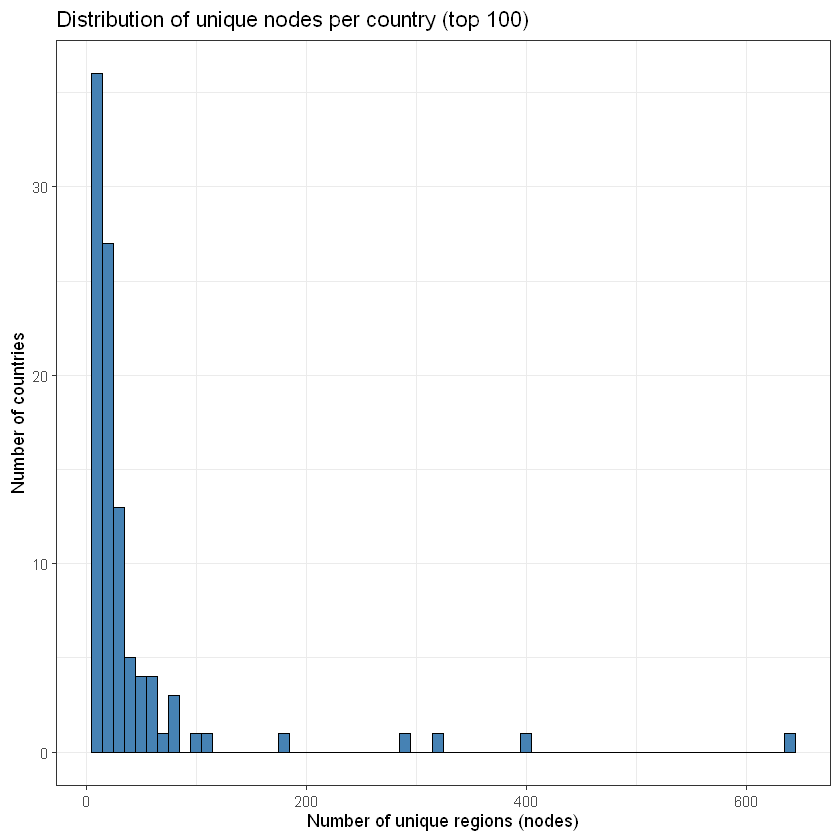

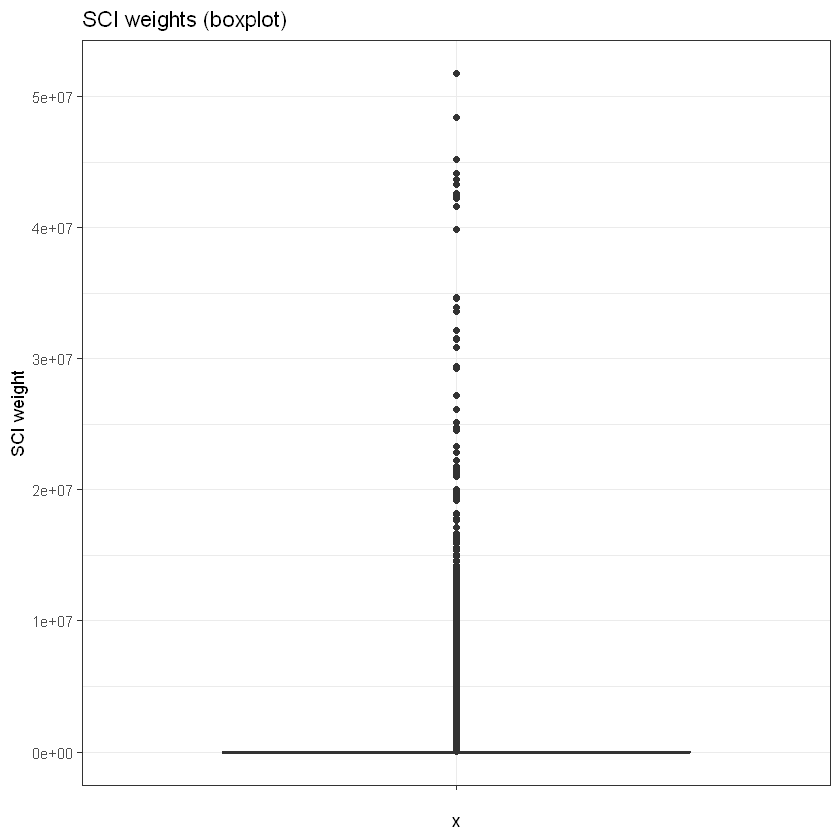

# A tibble: 40 × 9
   country nodes edges density diameter avg_degree avg_clustering
   <chr>   <dbl> <dbl>   <dbl>    <dbl>      <dbl>          <dbl>
 1 AGO        18   153       1   537513         17              1
 2 ALB        12    66       1   274742         11              1
 3 ARG        24   276       1    21690         23              1
 4 ARM        11    55       1   319282         10              1
 5 AUT        35   595       1    67875         34              1
 6 AZE        10    45       1    83991          9              1
 7 BDI        17   136       1  2540699         16              1
 8 BEL        44   946       1    20172         43              1
 9 BEN        12    66       1   509279         11              1
10 BFA        13    78       1   691677         12              1
# ℹ 30 more rows
# ℹ 2 more variables: avg_path_length <dbl>, avg_weight <dbl>


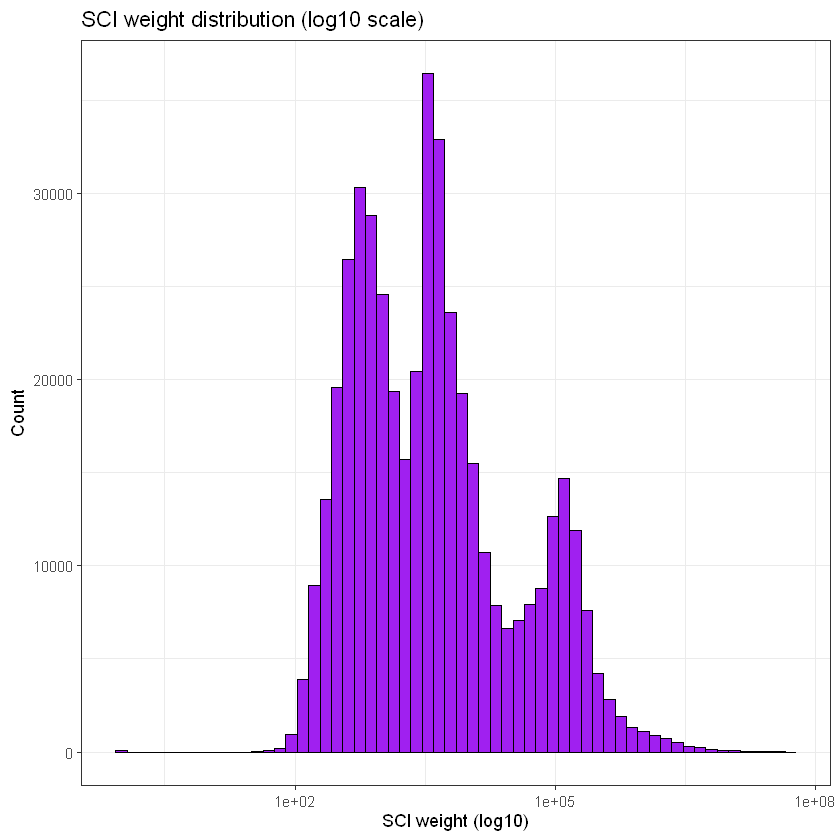

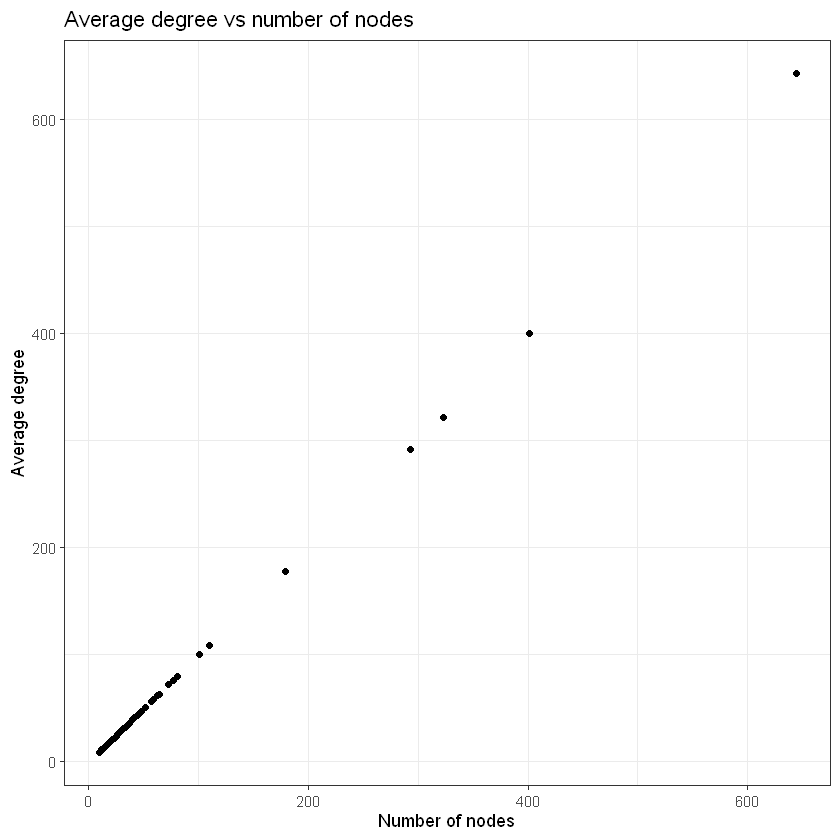

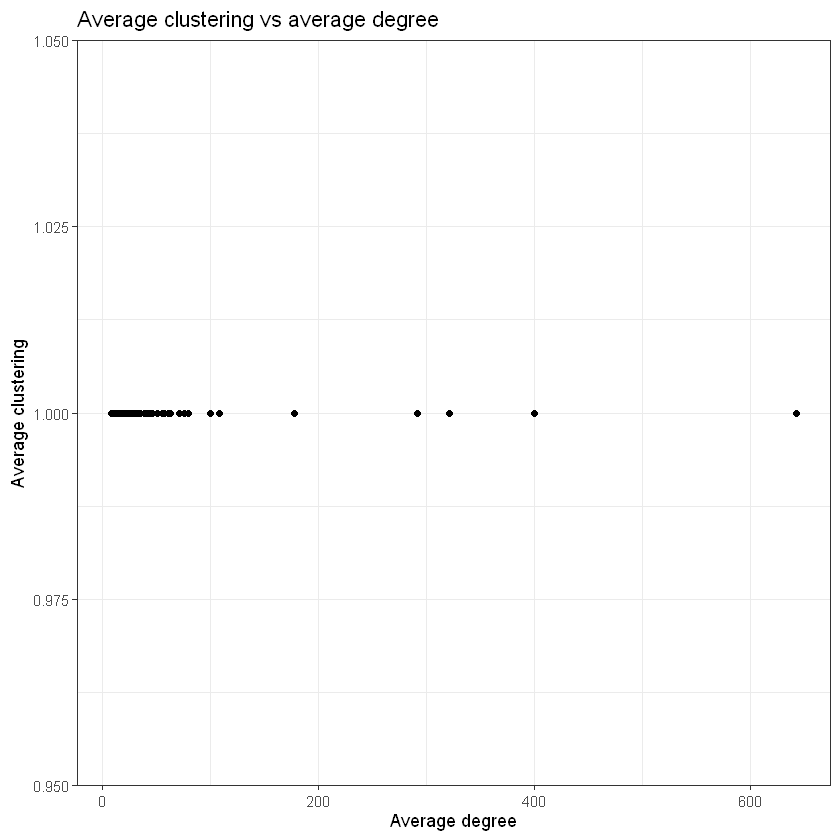

In [71]:
# =========================
# CELL 2 — EXPLORATION 
# =========================

library(ggplot2)
library(dplyr)
library(purrr)
library(igraph)

# ------------------------------------------------------------
# A) Basic dataset exploration (after cleaning)
# ------------------------------------------------------------

# How many unique nodes per country (top 100 set)?
nodes_per_country <- edges_top %>%
  group_by(country) %>%
  summarise(
    unique_nodes = n_distinct(c(user_loc, fr_loc)),
    total_edges  = n(),
    .groups = "drop"
  ) %>%
  arrange(desc(unique_nodes))

print(head(nodes_per_country, 30))

ggplot(nodes_per_country, aes(x = unique_nodes)) +
  geom_histogram(binwidth = 10, fill = "steelblue", color = "black") +
  labs(
    title = "Distribution of unique nodes per country (top 100)",
    x = "Number of unique regions (nodes)",
    y = "Number of countries"
  ) +
  theme_bw()

# SCI weight distribution (global, after merging symmetric duplicates)
weights_df <- edges_top %>% filter(!is.na(weight)) %>% select(weight)
print(summary(weights_df$weight))

ggplot(weights_df, aes(x = "", y = weight)) +
  geom_boxplot(fill = "orange") +
  labs(
    title = "SCI weights (boxplot)",
    y = "SCI weight"
  ) +
  theme_bw()

ggplot(weights_df, aes(x = weight)) +
  geom_histogram(fill = "purple", color = "black", bins = 60) +
  scale_x_log10() +
  labs(
    title = "SCI weight distribution (log10 scale)",
    x = "SCI weight (log10)",
    y = "Count"
  ) +
  theme_bw()

# ------------------------------------------------------------
# B) Build summary metrics for each country network
# ------------------------------------------------------------

summary_df <- map_dfr(names(network_list), function(iso3) {
  net <- network_list[[iso3]]
  if (is.null(net)) return(NULL)

  nodes <- net$nodes %>%
    transmute(name = as.character(nodeID), longitude, latitude)

  edges <- net$edges %>%
    transmute(from = as.character(nodeID_from), to = as.character(nodeID_to), weight)

  # Build undirected graph
  g <- graph_from_data_frame(edges, vertices = nodes, directed = FALSE)

  tibble(
    country = iso3,
    nodes = gorder(g),
    edges = gsize(g),
    density = edge_density(g),
    diameter = tryCatch(diameter(g), error = function(e) NA_real_),
    avg_degree = mean(degree(g)),
    avg_clustering = mean(transitivity(g, type = "localundirected", isolates = "zero"), na.rm = TRUE),
    avg_path_length = tryCatch(mean_distance(g), error = function(e) NA_real_),
    avg_weight = mean(E(g)$weight, na.rm = TRUE)
  )
}) %>%
  filter(!is.na(avg_degree) & avg_degree > 0)

print(head(summary_df, 40))

# Example plots for the simplified comparison (you can keep / adapt)
ggplot(summary_df, aes(x = nodes, y = avg_degree)) +
  geom_point() +
  labs(
    title = "Average degree vs number of nodes",
    x = "Number of nodes",
    y = "Average degree"
  ) +
  theme_bw()

ggplot(summary_df, aes(x = avg_degree, y = avg_clustering)) +
  geom_point() +
  labs(
    title = "Average clustering vs average degree",
    x = "Average degree",
    y = "Average clustering"
  ) +
  theme_bw()


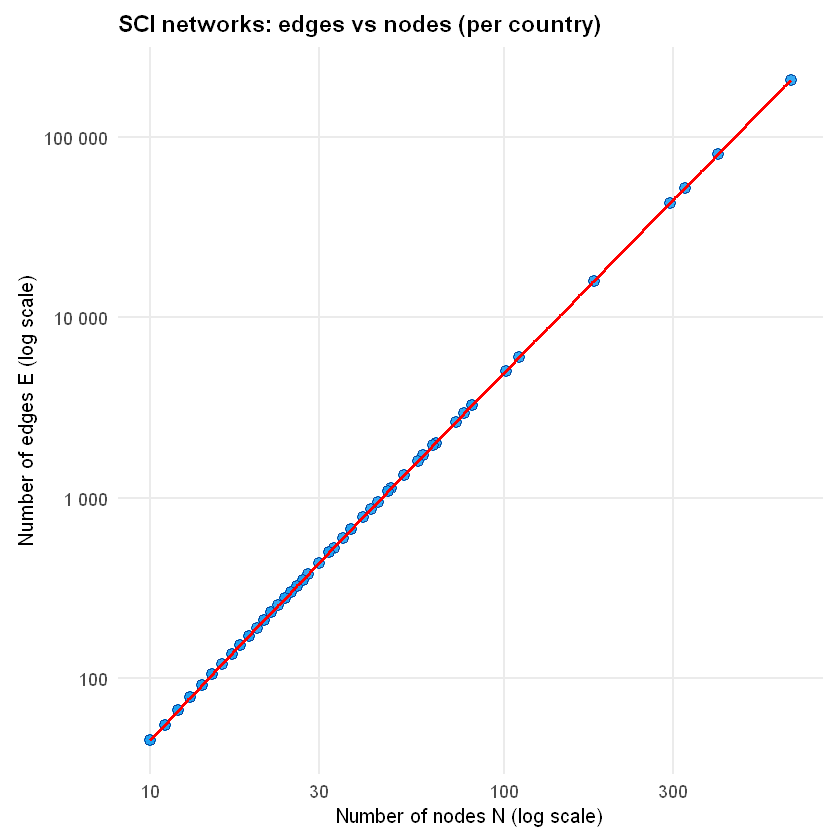

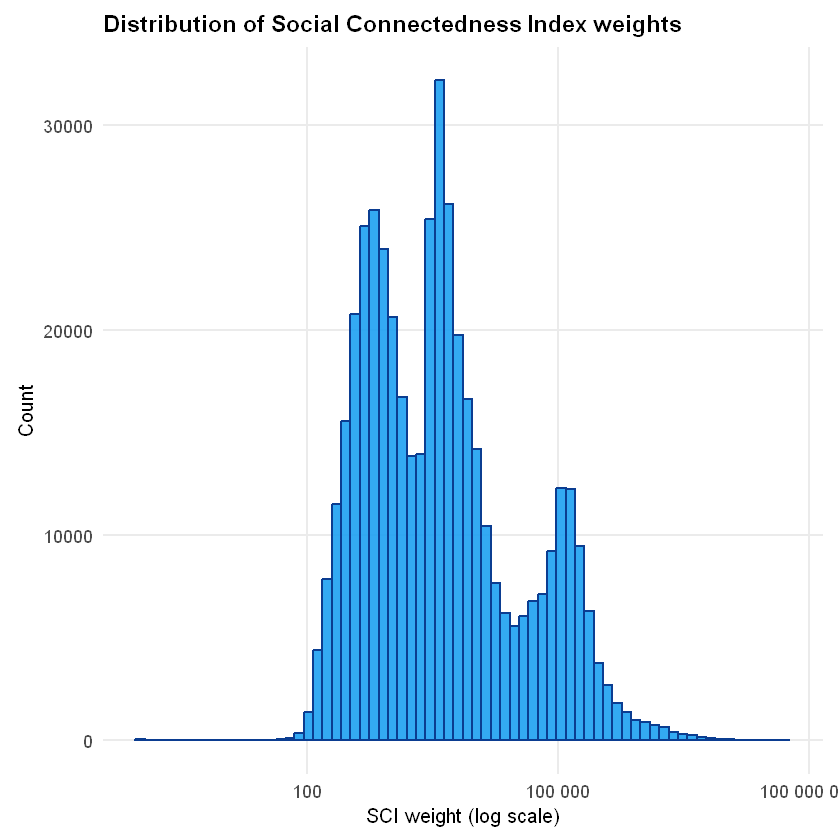

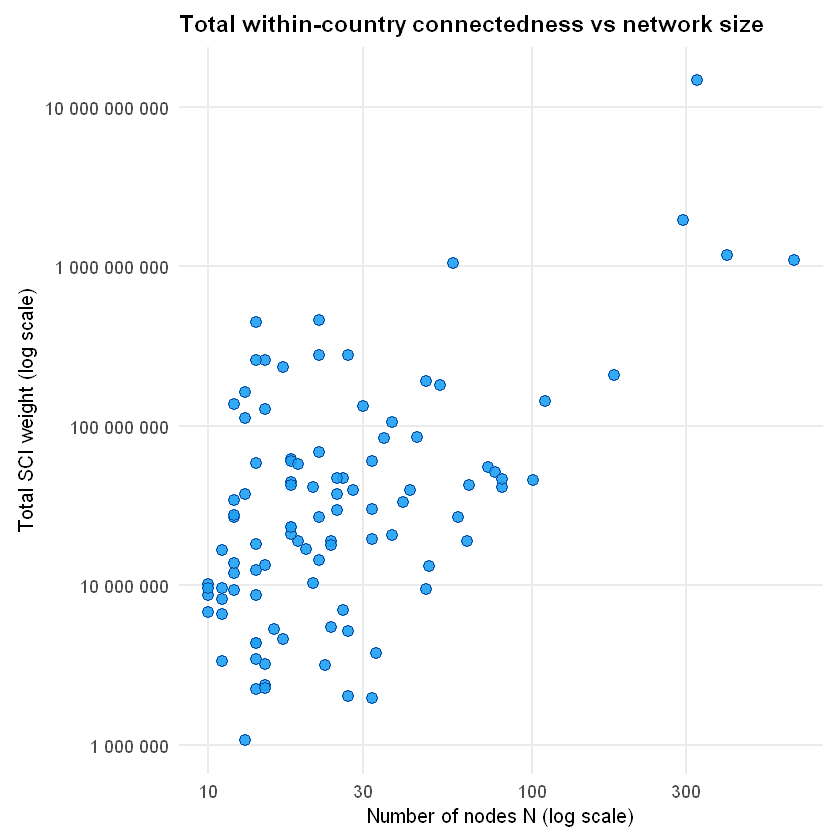

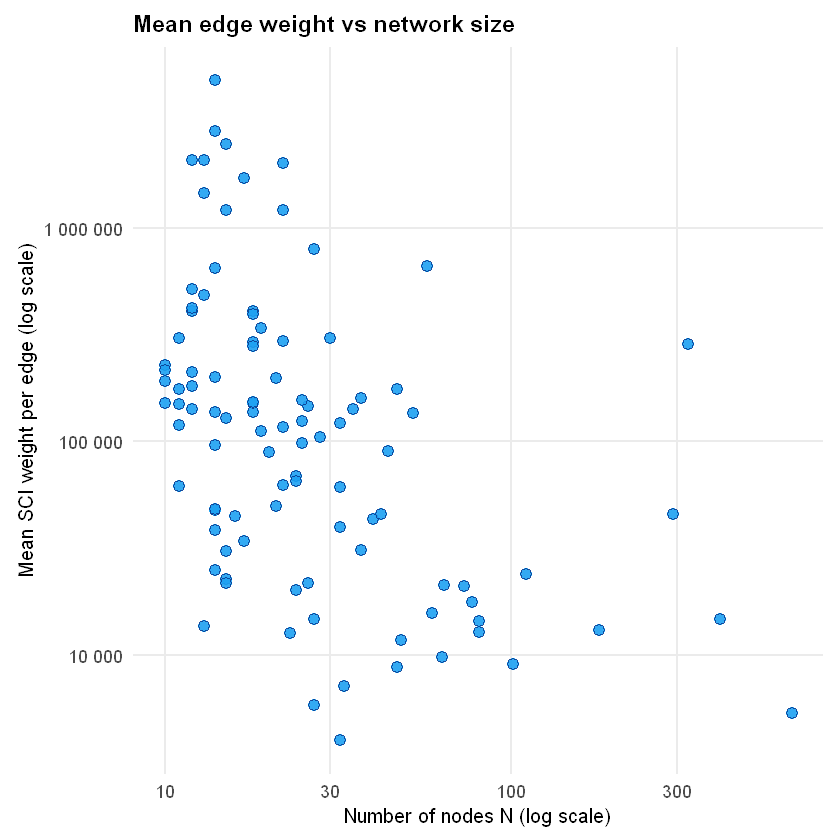

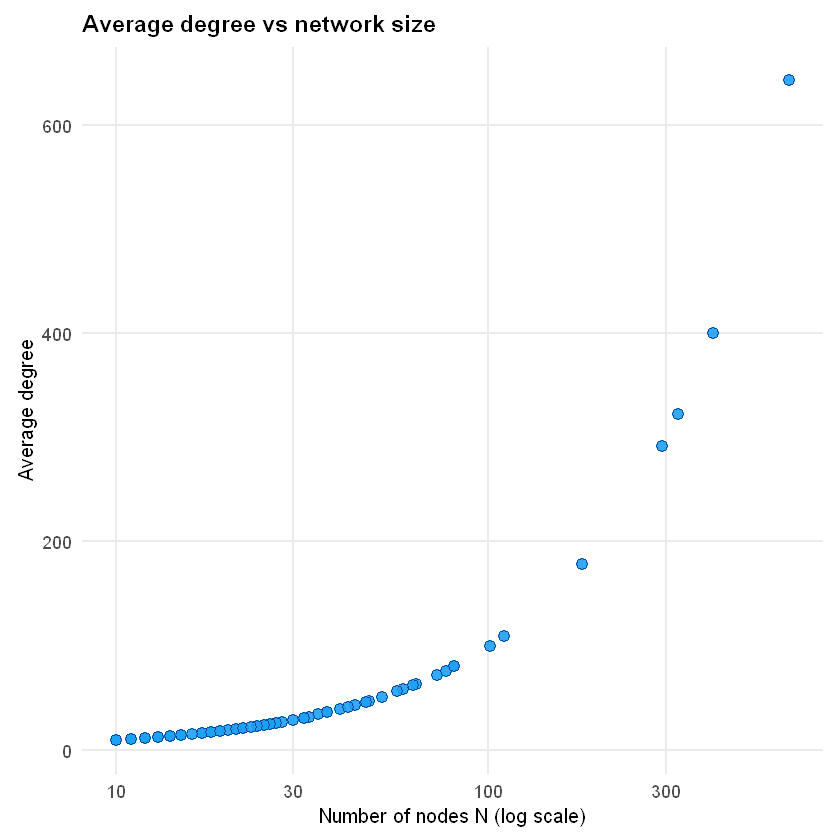

In [73]:

# =========================
# Figures
# =========================

# =========================
# FIGURE 1 — Edges vs Nodes (complete-graph reference)
# =========================
setwd("C:/Users/chiar/OneDrive/Desktop/Magistrale/manlio/project_44/latex")

# Safety check
stopifnot(all(c("N_nodes", "E_edges") %in% names(country_stats)))

p1 <- ggplot(country_stats, aes(x = N_nodes, y = E_edges)) +
  pt +
  stat_function(
    fun = function(n) n * (n - 1) / 2,
    color = "red",
    linewidth = 1.0
  ) +
  scale_x_log10(labels = label_number()) +
  scale_y_log10(labels = label_number()) +
  labs(
    title = "SCI networks: edges vs nodes (per country)",
    x = "Number of nodes N (log scale)",
    y = "Number of edges E (log scale)"
  ) +
  theme_report

print(p1)
save_both(p1, "fig1_edges_vs_nodes")

# =========================
# FIGURE 2 — SCI weight distribution (log scale)
# =========================

df_w <- edges_top %>%
  filter(!is.na(weight), weight > 0)

p2 <- ggplot(df_w, aes(x = weight)) +
  geom_histogram(
    bins = 70,
    fill = "#1DA1F2",
    color = "#0B3D91",
    alpha = 0.9
  ) +
  scale_x_log10(labels = label_number()) +
  labs(
    title = "Distribution of Social Connectedness Index weights",
    x = "SCI weight (log scale)",
    y = "Count"
  ) +
  theme_report

print(p2)
save_both(p2, "fig2_sci_weight_distribution")

# =========================
# FIGURE 3 — Total SCI vs network size
# =========================

p3 <- ggplot(country_stats, aes(x = N_nodes, y = total_weight)) +
  pt +
  scale_x_log10(labels = label_number()) +
  scale_y_log10(labels = label_number()) +
  labs(
    title = "Total within-country connectedness vs network size",
    x = "Number of nodes N (log scale)",
    y = "Total SCI weight (log scale)"
  ) +
  theme_report

print(p3)
save_both(p3, "fig3_total_weight_vs_nodes")

# =========================
# FIGURE 4 — Mean edge weight vs network size
# =========================

country_stats2 <- country_stats %>%
  mutate(mean_weight = total_weight / E_edges) %>%
  filter(is.finite(mean_weight), mean_weight > 0)

p4 <- ggplot(country_stats2, aes(x = N_nodes, y = mean_weight)) +
  pt +
  scale_x_log10(labels = label_number()) +
  scale_y_log10(labels = label_number()) +
  labs(
    title = "Mean edge weight vs network size",
    x = "Number of nodes N (log scale)",
    y = "Mean SCI weight per edge (log scale)"
  ) +
  theme_report

print(p4)
save_both(p4, "fig4_mean_weight_vs_nodes")

# =========================
# FIGURE 5 — Average degree vs network size
# =========================

summary_degree <- purrr::map_dfr(names(network_list), function(iso3) {
  net <- network_list[[iso3]]
  if (is.null(net)) return(NULL)

  g <- igraph::graph_from_data_frame(
    net$edges %>% select(nodeID_from, nodeID_to),
    directed = FALSE,
    vertices = net$nodes %>% select(nodeID)
  )

  tibble(
    country = iso3,
    N_nodes = gorder(g),
    avg_degree = mean(degree(g))
  )
})

p5 <- ggplot(summary_degree, aes(x = N_nodes, y = avg_degree)) +
  pt +
  scale_x_log10(labels = label_number()) +
  labs(
    title = "Average degree vs network size",
    x = "Number of nodes N (log scale)",
    y = "Average degree"
  ) +
  theme_report

print(p5)
save_both(p5, "fig5_avg_degree_vs_nodes")
